# NAMD recipe

This notebook will do the NA-MD calculations and all the needed analysis for you. You just need to generate suitable input data, place it in correct places, and select appropriate parameters for the simulations below.

------------------------
Import all the definitions

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.decoherence_times as decoherence_times
from libra_py import data_conv
from libra_py import data_stat
from libra_py import data_outs
from libra_py import fit
from libra_py import influence_spectrum as infsp


import matplotlib.pyplot as plt   # plots
import numpy as np
from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]



def plot_map(ax, energy, X):
    
    colormap =  "plasma" # "Blues" # options: plasma, viridis, binary, hot, etc.
    
    npts = len(energy)
    
    emin = energy[0]
    emax = energy[npts-1]
    
    extent=(emin, emax, emin, emax)
    
    xs0, ys0, zs0 = [], [], []

    for i in xrange(npts):    
        for j in xrange(npts):
            xs0.append(energy[i])
            ys0.append(energy[j])
            zs0.append(X[i][j])

    N = 30j
    xs,ys = np.mgrid[extent[0]:extent[1]:N, extent[2]:extent[3]:N]
    zs = griddata(xs0, ys0, zs0,  xs, ys, interp="linear")

    #ax.xticks(energy, rotation=30)
    #ax.yticks(energy, rotation=30)    
    
    ax.xticks(rotation=30)
    ax.yticks(rotation=30)
            
    ax.imshow(zs.T, cmap=colormap, extent=extent, interpolation='Lanczos', origin='lower')
    ax.plot(xs0, ys0, "ro")
    ax.colorbar()

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<in

## 1. Get Data 

Read in all the data sets. Form the sub-Hamiltonians for all data set (active space)

In [2]:
params = {}

# Folders with data sets
params["data_set_paths"] = ["traj1/", "traj2/"]

# How many files in each folder
params["nfiles"] = 30

# Prefix of the files with energies (re) and couplings (im)
params["Hvib_re_prefix"] = "Hvib_"
params["Hvib_im_prefix"] = "Hvib_"

# Suffix of the files with energies (re) and couplings (im)
params["Hvib_re_suffix"] = "_re"
params["Hvib_im_suffix"] = "_im"

# The number of lines/cols in each file
params["nstates"] = 4

# Select the active states
params["active_space"] = [1,2,3]


Hvib = step4.get_Hvib2(params)
T = [i for i in xrange(len(Hvib[0])) ]

Visualize couplings and energies

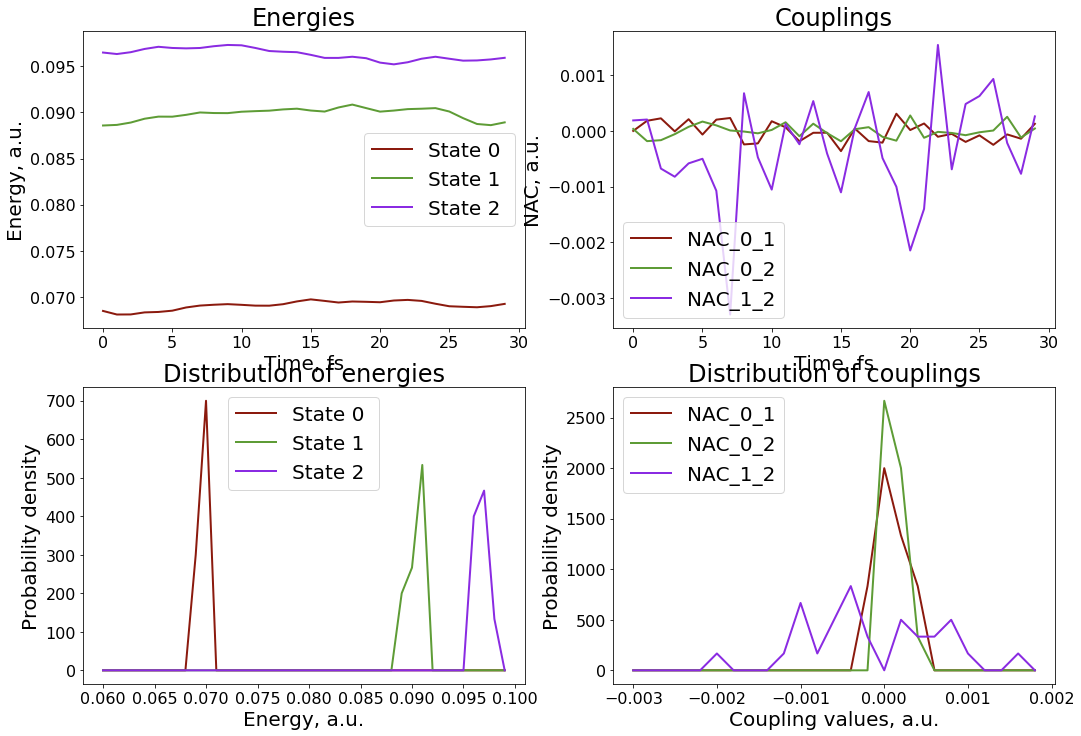

In [3]:
states = [0, 1, 2]
nst = len(states)

plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,2)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()


plt.subplot(2,2,3)
plt.title('Distribution of energies')
plt.xlabel('Energy, a.u.')
plt.ylabel('Probability density')

for i in xrange(nst):
    st = states[i]
    bin_supp, dens, cum = data_stat.cmat_distrib(Hvib[0], st, st, 0, 0.06, 0.10, 0.001)    
    plt.plot(bin_supp, dens, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,4)
plt.title('Distribution of couplings')
plt.xlabel('Coupling values, a.u.')
plt.ylabel('Probability density')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        bin_supp, dens, cum = data_stat.cmat_distrib(Hvib[0], st1, st2, 1, -0.003, 0.002, 0.0002)    
        plt.plot(bin_supp, dens, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]])     
        cnt = cnt + 1
plt.legend()

plt.show()
plt.close()

Also, compute the map of the averaged couplings and plot it as a 2D picture

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


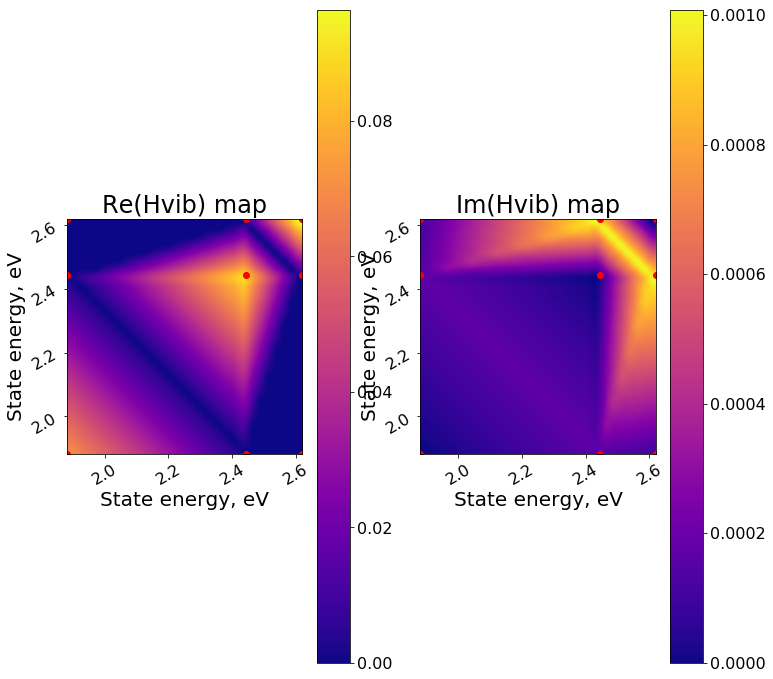

In [7]:
opt = 2
Hvib_ave = data_stat.cmat_stat2(Hvib[0], opt)

x, y, Hvib_data_re = data_outs.show_matrix_pyplot(Hvib_ave.real(), 0)
x, y, Hvib_data_im = data_outs.show_matrix_pyplot(Hvib_ave.imag(), 0)

# Energy axis in eV
e = []
sz = Hvib_ave.num_of_cols
for i in xrange(sz):
    e.append(Hvib_ave.get(i,i).real * units.au2ev)
        

plt.figure(1, figsize=(12, 12)) # dpi=300, frameon=False)
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels


plt.subplot(1,2,1)
plt.title('Re(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_re)


plt.subplot(1,2,2)
plt.title('Im(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_im)

plt.show()
plt.close()

## 2. Transform the Data if needed

Scale or transform your data according to your needs. Use any of the possible options:

* data_conv.unit_conversion(Hvib, scaling_factor) - simple multiplicative scaling of Hvib
* data_conv.scale_NACs(Hvib, scaling_factor) - rescale all the NACs by a uniform factor
* data_conv.scale_NAC(Hvib, a, b, scaling_factor)  - rescale only a selected NAC
* data_conv.scissor(Hvib, a, dE) - shift all the levels starting with "a" by dE

In [8]:
data_conv.scale_NACs(Hvib, 10.0)
data_conv.scissor(Hvib, 1, -0.01)

Use the default value =  <liblibra_core.CMATRIX object at 0x7ff5b6aa8f18>
Use the default value =  <liblibra_core.CMATRIX object at 0x7ff5b6aa8f18>


Transformed data

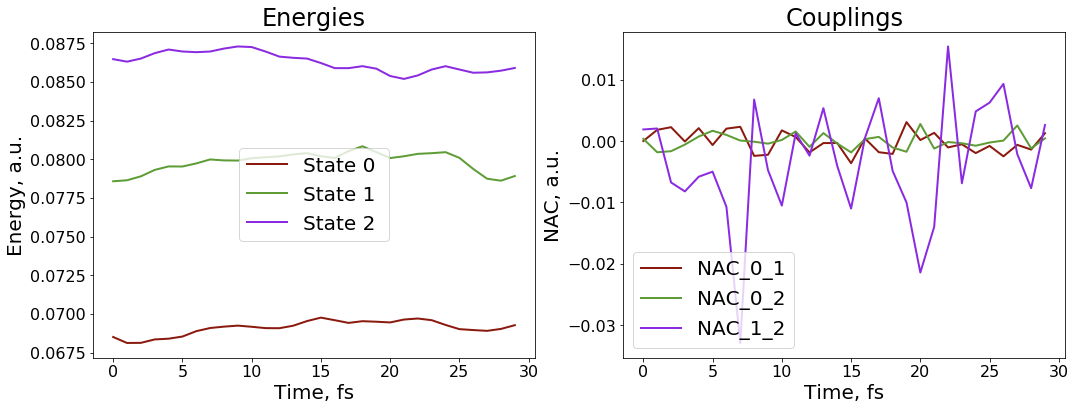

In [9]:
plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()

plt.show()
plt.close()

## 3. Decoherence Times

In [10]:
itimes = [0, 0]
nsteps = len(Hvib[0])
verbosity = 0
tau, rates = decoherence_times.decoherence_times_ave(Hvib, itimes, nsteps, verbosity)

nst = Hvib[0][0].num_of_cols
for i in xrange(nst):
    for j in xrange(i+1, nst):
        print "tau-%i-%i = " % (i,j), tau.get(i,j) * units.au2fs, " fs"

tau-0-1 =  86.3259302274  fs
tau-0-2 =  41.4992019959  fs
tau-1-2 =  41.3366629917  fs


## 4. Influence Spectrum

Compute energy gaps, averaged (<dE^2>) over the trajectories and time

In [11]:
dE = decoherence_times.energy_gaps_ave(Hvib, itimes, nsteps)

Compute the distributions of energy gaps and plot them

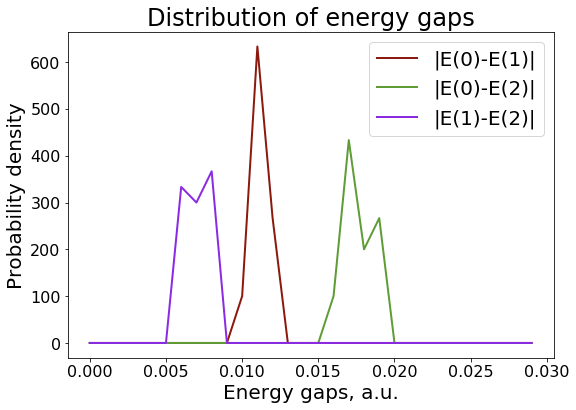

In [12]:
states = [0, 1, 2]
nst = len(states)

plt.figure(1, figsize=(9, 6)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Distribution of energy gaps')
plt.xlabel('Energy gaps, a.u.')
plt.ylabel('Probability density')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        bin_supp, dens, cum = data_stat.cmat_distrib(dE, st1, st2, 0, 0.0, 0.03, 0.001)    
        plt.plot(bin_supp, dens, label='|E(%i)-E(%i)|' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]])     
        cnt = cnt + 1
plt.legend()

plt.show()
plt.close()

In [13]:
params = {}
params["dt"] = 1.0        # MD timestep in fs
params["wspan"] = 3000.0  #  cm^-1
params["dw"] = 1.0        # cm^-1
params["do_output"] = False
params["do_center"] = True
params["acf_type"] = 1
params["data_type"] = 0


In [14]:
states = [0, 1, 2]
nst = len(states)

ACF, W, J2 = [], [], []
for i in xrange(nst):
    for j in xrange(i+1,nst):
        
        data_ij = []        
        for de in dE:
            x = MATRIX(1,1)
            x.set(0,0, de.get(i,j))
            data_ij.append(x)

        Tij, ACFij, uACFij, Wij, Jij, J2ij = infsp.recipe1(data_ij, params)
        
        ACF.append(ACFij)
        W.append(Wij)
        J2.append(J2ij)

Use the default value =  spectrum.txt
Use the default value =  acf.txt


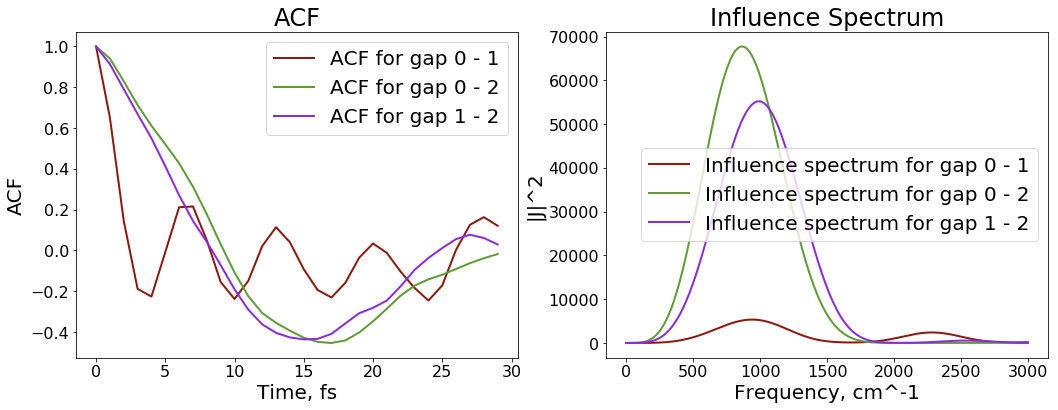

In [15]:
plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('ACF')
plt.xlabel('Time, fs')
plt.ylabel('ACF')
count = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1,nst):
        st2 = states[j]
        
        plt.plot(T, ACF[count], label='ACF for gap %i - %i' % (st1, st2), linewidth=2, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend()


plt.subplot(1,2,2)
plt.title('Influence Spectrum')
plt.xlabel('Frequency, cm^-1')
plt.ylabel('|J|^2')
count = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1,nst):
        st2 = states[j]        
        plt.plot(W[count], J2[count], label='Influence spectrum for gap %i - %i' % (st1, st2), linewidth=2, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend()

plt.show()
plt.close()

## 5. Nonadiabatic Dynamics 

Define simulation parameters

In [16]:
params = {}

# Trajectory:
params["dt"] = 41.0  # in a.u. of time

# Thermals:
params["T"] = 300.0           # in K
params["Boltz_opt"] = 1       # options: 0 (no), 1 (Pyxaid), 2 (Classical), 3 (N-state Boltzmann)

# Statistics:
params["ntraj"] = 1000

# TSH:
params["sh_method"] = 1       # 0 - MSSH, 1 - FSSH

# Decoherence:
params["decoherence_constants"] = 0   # decoherence times from the data
params["decoherence_method"] = 1      # 0 (no), 1 (ID-A), 2 (mSDM), 3 (DISH)

# Simulation:
params["istate"] = 1
params["init_times"] = [0, 0]
params["nsteps"] = 30   # can not be larger than len(Hvib)

# Outputs:
params["outfile"] = "_out.txt"

res = step4.run(Hvib, params)

Decoherence times matrix (a.u. of time):
Decoherence times matrix (fs):
Decoherence rates matrix (a.u.^-1):


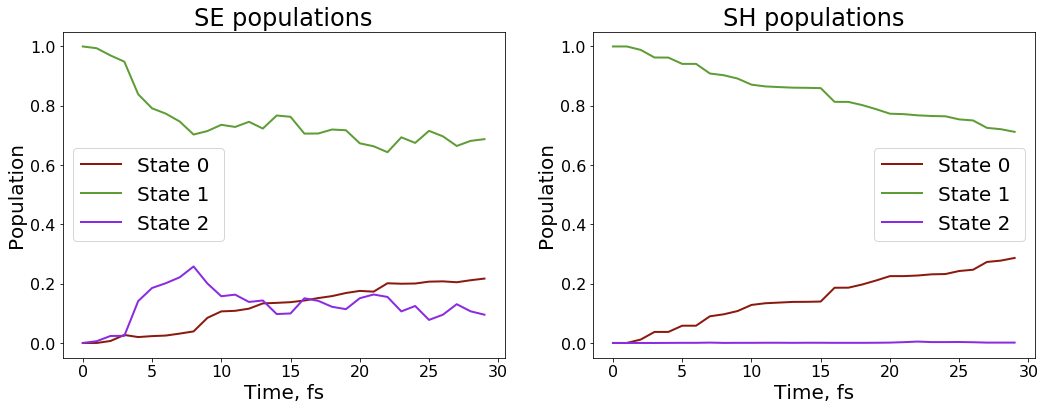

In [17]:
# nstates = 2 => n_cols = 2*3 + 5 = 10
#        0    1      2     3    4      5      6     7     8    9   10
# res =  t  E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH

states = [0, 1, 2]
nst = len(states)

plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('SE populations')
plt.xlabel('Time, fs')
plt.ylabel('Population')
for i in xrange(nst):
    st = states[i]
    Pi = data_conv.unpack2(res, 1+ 3*st+1)    
    plt.plot(T, Pi, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('SH populations')
plt.xlabel('Time, fs')
plt.ylabel('Population')
for i in xrange(nst):
    st = states[i]
    Pi = data_conv.unpack2(res, 1+ 3*st+2)    
    plt.plot(T, Pi, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()

plt.show()
plt.close()

SLG data gives: A =  1.0  and B =  0.0118331110542  1/B =  84.5086296762  fs


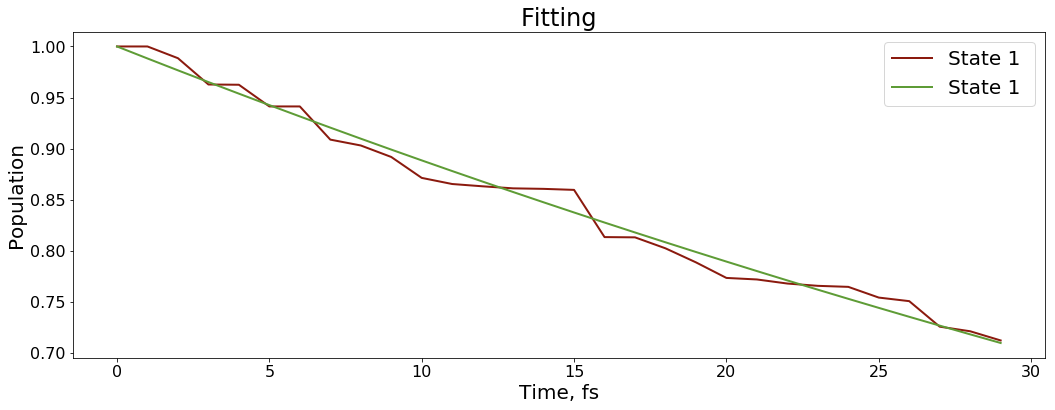

In [18]:
st = 1
P_st = data_conv.unpack2(res, 1+ 3*st+2)    

verb, opt = 0, 0
Pfit1, A1, B1 = fit.fit_exp(T, P_st, 0.0, verb, opt)  
print "SLG data gives: A = ", A1, " and B = ", B1, " 1/B = ", 1/B1, " fs"

plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Fitting')
plt.xlabel('Time, fs')
plt.ylabel('Population')

plt.plot(T, P_st, label='State %i ' % (st), linewidth=2, color = colors["11"]) 
plt.plot(T, Pfit1, label='State %i ' % (st), linewidth=2, color = colors["21"]) 

plt.legend()